<a href="https://colab.research.google.com/github/brittabeta/Learning-Sandbox/blob/main/AppUserSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# App User Engagement

Use segmentation to analyze app user behaviour. App users either kept the app (retained customer) or deleted the app (churn customer).

Goals
* help the app developers and business understand users
* improve user experience
* drive user retention


# Importing Libraries

In [1]:
# data loading and transformation tools
import pandas as pd
import numpy as np
# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# warnings and ignore for ease of reading notebook
import warnings
warnings.filterwarnings("ignore")
# set seed
random_seed = 42

# Loading Data

In [2]:
# import app use data
path = '/content/userbehaviour.csv'
df = pd.read_csv(path)
df.head()

,userid,Average Screen Time,Average Spent on App (INR),Left Review,Ratings,New Password Request,Last Visited Minutes,Status
0,1001,17.0,634.0,1,9,7,2990,Installed
1,1002,0.0,54.0,0,4,8,24008,Uninstalled
2,1003,37.0,207.0,0,8,5,971,Installed
3,1004,32.0,445.0,1,6,2,799,Installed
4,1005,45.0,427.0,1,5,6,3668,Installed


In [4]:
# obtain number of rows and columns
df.shape

(999, 8)

About the Data
* source: statso.io
* features:
* userid: id of user
* average screen time: average screen time of the user on the app, minutes
* average spent on app: average money spent on app, INR = Indian Rupee, 1 INR ~ 0.012 USD
* left review: user reviews, yes = 1, no = 0
* ratings: user rating of the app
* new password request: number of requests by user
* last visited minutes: minutes since last active 
* status: installed or deleted

# Data Cleaning and Feature Engineering

In [5]:
# check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   userid                      999 non-null    int64  
 1   Average Screen Time         999 non-null    float64
 2   Average Spent on App (INR)  999 non-null    float64
 3   Left Review                 999 non-null    int64  
 4   Ratings                     999 non-null    int64  
 5   New Password Request        999 non-null    int64  
 6   Last Visited Minutes        999 non-null    int64  
 7   Status                      999 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 62.6+ KB


In [19]:
# check number of unique values per column
for col in df:
  print(col, df[col].nunique())

userid 999
Average Screen Time 51
Average Spent on App (INR) 606
Left Review 2
Ratings 11
New Password Request 15
Last Visited Minutes 938
Status 2


In [23]:
# get values for status column
df.Status.unique()

array(['Installed', 'Uninstalled'], dtype=object)

In [24]:
# encode status column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Status'] = le.fit_transform(df['Status'])
mapping = dict(zip(le.classes_, range(0, len(le.classes_))))
print(mapping)

{'Installed': 0, 'Uninstalled': 1}


In [63]:
# obtain descriptive statistics 
df.describe()

,Average Screen Time,Average Spent on App (INR),Left Review,Ratings,New Password Request,Last Visited Minutes,Status
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,24.390390,424.415415,0.497497,6.513514,4.941942,5110.898899,0.083083
std,14.235415,312.365695,0.500244,2.701511,2.784626,8592.036516,0.276146
min,0.000000,0.000000,0.000000,0.000000,1.000000,201.000000,0.000000
25%,12.000000,96.000000,0.000000,5.000000,3.000000,1495.500000,0.000000
50%,24.000000,394.000000,0.000000,7.000000,5.000000,2865.000000,0.000000
75%,36.000000,717.500000,1.000000,9.000000,7.000000,4198.000000,0.000000
max,50.000000,998.000000,1.000000,10.000000,15.000000,49715.000000,1.000000


In [61]:
# drop the user id column
df = df.drop('userid', axis = 1)

Look at relationships and distribution in those retained (0) vs churn (1)

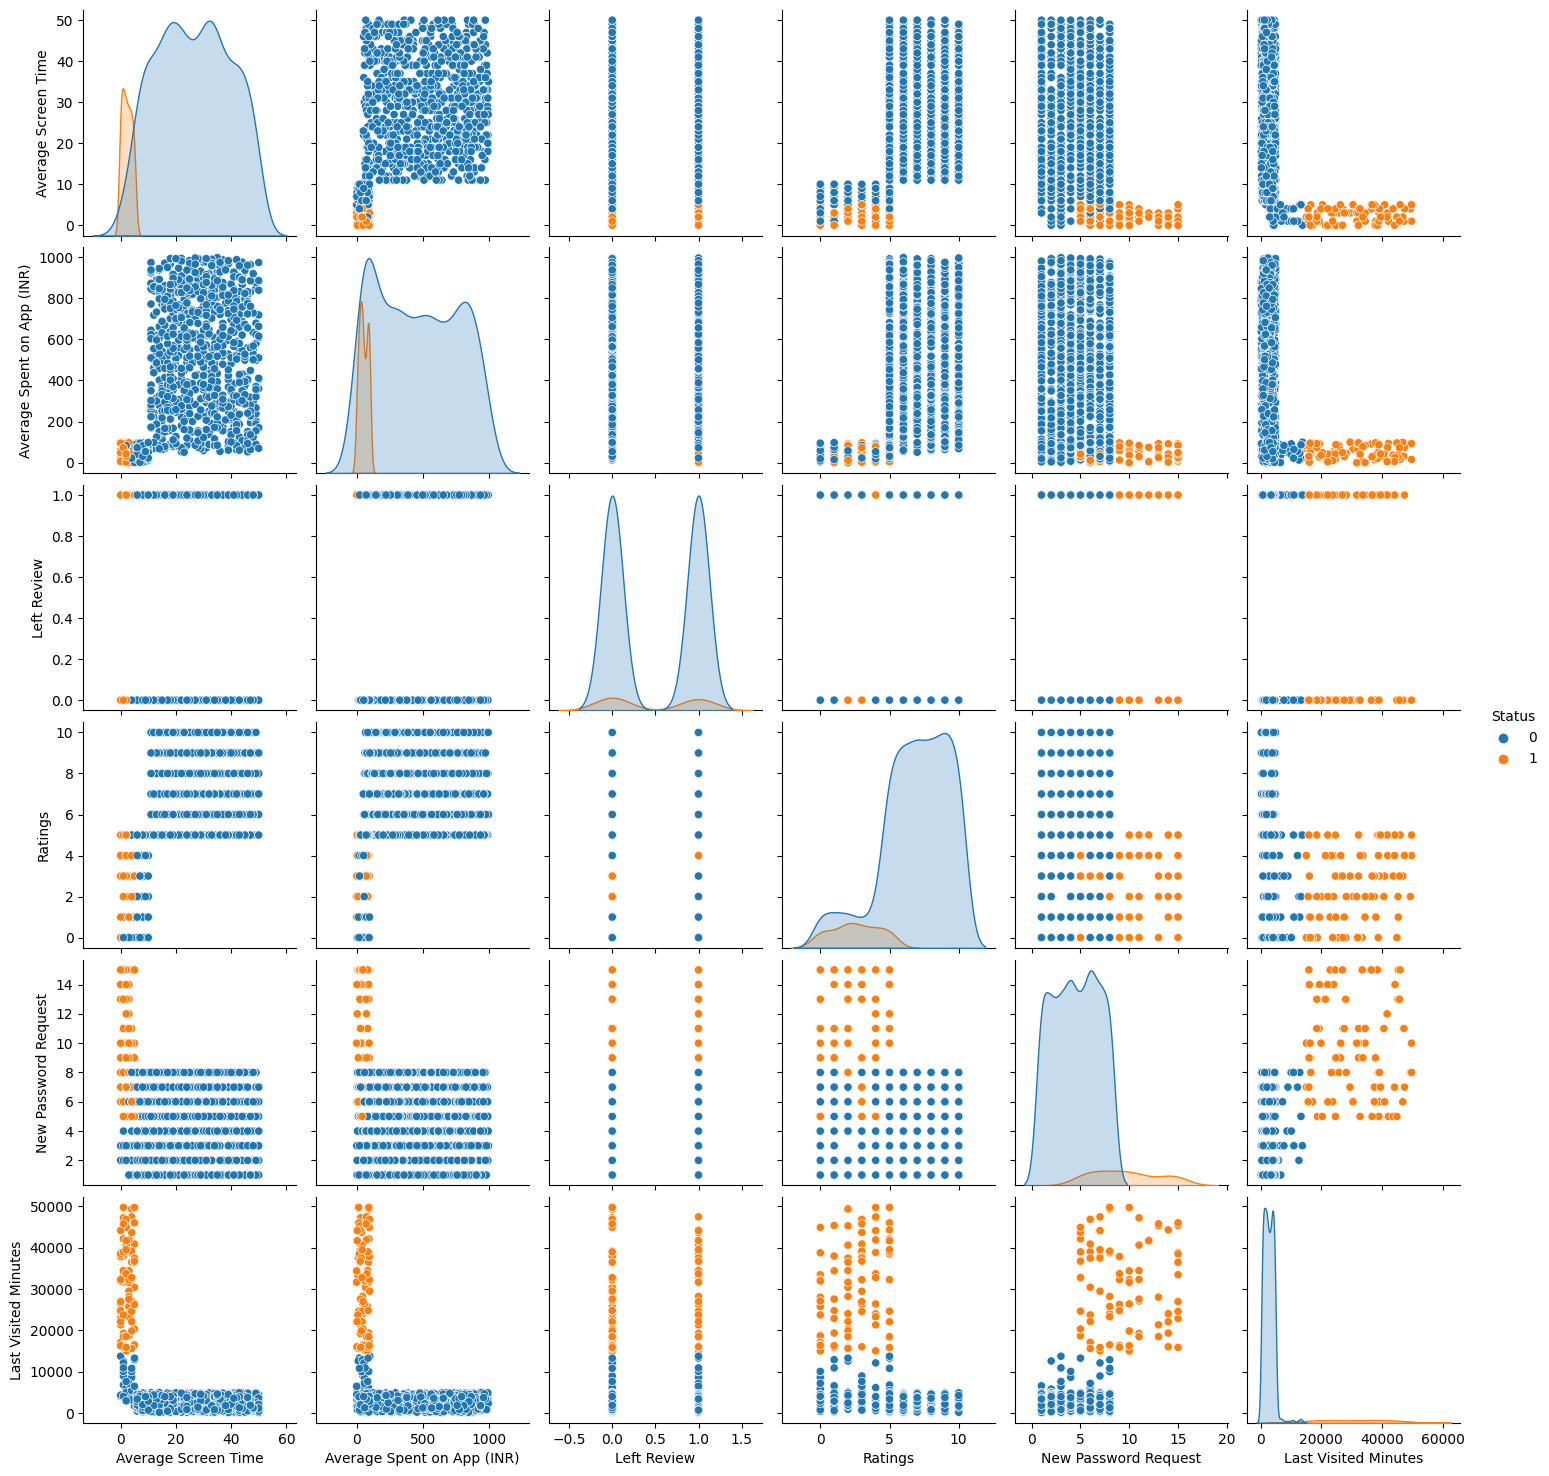

In [62]:
sns.pairplot(data=df, hue = 'Status')

Distributions

Average Screen Time
* Churn user screen time is less than the majority of retained users, with screen times concentrated between ~ 0 and 10 minutes

Average Spent on App (INR)
* Churn user spending is less than the majority of retained users, with amount spent ~ 0 INR

Left Review
* Churn users left fewer reviews than retained users

Ratings
* Churn users rated the app at 5 or less, while retained users more commonly rated the app 5 or greater

New Password Request
* Churn users made had higher maximum reset requests, while retained users made fewer than 10 requests

Last Visited Minutes
* Churn users of course have not used the app as they no longer have it installed; retained customers have a trailing subset that have not utilized the app in some time.


# Preprocessing

In [65]:
# scaling the data
target = df['Status']
data = df[["Average Screen Time", "Left Review", 
                        "Ratings", "Last Visited Minutes", 
                        "Average Spent on App (INR)", 
                        "New Password Request"]]

from sklearn.preprocessing import MinMaxScaler
for i in data.columns:
    MinMaxScaler(i)

In [66]:
data.head()

,Average Screen Time,Left Review,Ratings,Last Visited Minutes,Average Spent on App (INR),New Password Request
0,17.0,1,9,2990,634.0,7
1,0.0,0,4,24008,54.0,8
2,37.0,0,8,971,207.0,5
3,32.0,1,6,799,445.0,2
4,45.0,1,5,3668,427.0,6


# KMeans Estimator

Place each user into a cluster.

n_clusters is the number of clusters, the k-means clustering algorithm's hyperparameter k, which KMeans requires to calculate the clusters and label each user.  When the KMeans estimator is trained, the algorithm calculates for each cluster a centroid representing the cluster's center data point.

Once the model is fit/trained, the kmeans object contains: labels_ array with values 0 to n_clusters -1 indicating the clusters to which the users belong, and cluster_centers_ array in which each row represents a centroid.

In [69]:
from sklearn.cluster import KMeans

If we used 2 as there are those that retain the app or do not, we would predict KMeans to cluster users into retained or churn.  

If we use 3, we can gather further insight.